<h1 id="Title">Topographic Differencing and Error Analysis Toolkit</h1>
 


<h2 id="Setup">1. Setup</h2>

<h3 id="API-Key">Finding and storing your API Key</h3>


We recommend storing your OT API key in a environment variable. This prevents keys from being hardcoded in the source code, reducing the risk of exposure through sharing or version control. It also enhances flexibility, allowing the same code to be used in various environments without changes. Below are the steps to take to store your API key in an environment variable.  

<h4 id="Linux-macOS">For Linux/macOS</h4>

Open up a Terminal window and find your shell's profile script. For Bash, you might find '~ /.bashrc' or '~ /.bash_profile'.
For Zsh, you might find '~ /.zshrc'.  

```cd ~```  
```ls -a```  

Once you know the name of your shell’s profile script, you can edit it using a text editor that operates in the terminal (like ```nano``` or ```vim```) or out side the terminal with the text editor of your choosing. This example will use '~/.zshrc' as the name of the shell profile script and ```nano``` as the text editor. If the file is read-only, you might need to use ```sudo``` to edit it.  

```nano ~/.zshrc```  

At the end of the .zshrc file, add a line to define your environment variable. 'your_api_key_here' is a stand in for the alphanumeric API key accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."   
 
```export OPENTOPOGRAPHY_API_KEY='your_api_key_here'```


Exit (```control + X``` for ```nano```) and save (```Y``` to ```Save modified buffer (ANSWERING "No" WILL DESTROY CHANGES) ?``` then ```Enter``` for ```nano```).

For your changes to take effect, you need to reload the .zshrc file or restart your terminal. To reload .zshrc without restarting, type the following command in your terminal and press Enter:  

```source ~/.zshrc```  

This will make the OPENTOPOGRAPHY_API_KEY environment variable available in all new terminal sessions.  

<h4 id="Windows">For Windows</h4> 

1. Search for "Environment Variables" in the Start menu.
1. Click on "Edit the system environment variables."
1. In the System Properties window, click on "Environment Variables."
1. Click on "New" under System variables or User variables depending on your need.
1. Set "Variable name" as OPENTOPOGRAPHY_API_KEY and "Variable value" as your actual API key. Your alphanumeric API key is accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."
1. Click OK and apply the changes.

<h3 id="Colab">Running the notebook in Colab</h3>


In [2]:
# This cell only excecutes if you're running on Colab. Installation process takes 2-3 minutes.
import os, sys
if 'google.colab' in sys.modules:
    
  # Mount Google Drive. You will be prompted to grant file I/O access to Drive.
  from google.colab import drive 
  drive.mount('/gdrive/') # Mount Google Drive! 

  # Clone OpenTopography 3DEP Workflow Git Repository
  !git clone https://github.com/Cassandra-Brigham/sage-gage-exercise

  #  Install the core dependencies (other than PDAL/GDAL) from requirements.txt
  !pip install -r sage-gage-exercise/requirements.txt

  # Install Conda (necessary to install PDAL/GDAL)
  !pip install -q condacolab
  import condacolab
  condacolab.install()

  #kernel will restart. Install PDAL and GDAL with Mamba.
  !mamba install -q python-pdal gdal
  
  # Runtime will restart automatically. Do not rerun above cells.

In [3]:
# This cell only excecutes if you're running on Colab.
import os, sys
if 'google.colab' in sys.modules:
    # Colab requires proj_lib environment variable to be set manually.
    os.environ['PROJ_LIB'] = '/usr/local/share/proj/'

    !pip install python-dotenv  # if not already installed

    from dotenv import set_key, find_dotenv

    # 1) Locate (or create) your .env
    #    find_dotenv returns the first .env in cwd hierarchy, or '' if none
    env_path = find_dotenv(usecwd=True)
    if not env_path:
        env_path = ".env"
        open(env_path, "a").close()

    # 2) Define your variables
    variables = {
        "OPENTOPOGRAPHY_API_KEY": os.getenv("OPENTOPOGRAPHY_API_KEY", "default_value"),
    }

    # 3) Write/update each key in the .env
    for key, val in variables.items():
        set_key(env_path, key, val)

    print(f".env updated at {env_path}")

In [1]:
# Install required libraries
!pip install numpy pandas matplotlib requests rioxarray rasterio shapely scipy numba geopandas pdal

<h3 id="Libraries">Import required libraries</h3>

In [23]:
import importlib
import topographic_processing18
import colormaps as cmaps
import os
#import lib.reload(topographic_processing18)
# Import the module
from topographic_processing18 import DataAccess, OpenTopographyQuery, Raster, RasterPair, GeoidTransformer, GetDEMs, TerrainDerivatives, TopoDifferencer, TopoDiffProcessor

<h2 id="Data-Access-and-Processing">2. Data access, download and pre-processing</h2>
<h3 id="Load-API-Key">Load API key</h2>

In [2]:
# After setting the environment variable, access your API key in this notebook.
API_Key = os.getenv('OPENTOPO_ADMIN_ENTERPRISE_API_KEY')

# If your API key is not set, you can set it here.
# API_Key = "your_api_key_here"

if API_Key is not None:
    print("API Key loaded successfully!")
else:
    print("Failed to load API Key.")

API Key loaded successfully!


<h3 id="Define-AOI"> Define area of interest</h3>

To specify the geographic region for your dataset search, you have three options. You can 1) manually enter latitude and longitude bounds if you know the exact coordinates of your area of interest; 2) upload a shapefile or GEOJSON to automatically populate the same extent variables; 3) draw a bounding box directly on the interactive map embedded in this notebook: simply click and drag to sketch the rectangle around your target area, and the notebook captures both the corner coordinates and the equivalent WKT polygon for your API queries.

<h4 id="Option-1-Draw-Map"> Option 1: Draw a bounding box on an interactive map</h4>

In [3]:
da = DataAccess()
da.init_ot_catalog_map(zoom=3)

Map(center=[39.8283, -98.5795], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [4]:
da.bounds

{'south': 41.455079,
 'west': -85.11795,
 'north': 41.472573,
 'east': -85.083618,
 'polygon_wkt': ['-85.11795, 41.455079, -85.11795, 41.472573, -85.083618, 41.472573, -85.083618, 41.455079, -85.11795, 41.455079']}

<h4 id="Option-2-Manual-Bounds"> Option 2: Define bounds manually</h4>

In [4]:
da = DataAccess()
south = 41.41898
north = 41.419882
west = -84.982467
east = -84.98148
da.define_bounds_manual(south, north, west, east)

{'south': 41.41898,
 'north': 41.419882,
 'west': -84.982467,
 'east': -84.98148,
 'polygon_wkt': ['-84.98148, 41.41898, -84.98148, 41.419882, -84.982467, 41.419882, -84.982467, 41.41898, -84.98148, 41.41898']}

<h4 id="Option-3-Upload-File">Option 3: Define bounds using an uploaded file</h4>

In [4]:
path = "path/to/shapefile.shp"

da = DataAccess()

da.define_bounds_from_file(path, target_crs = 'EPSG:4326')

KeyboardInterrupt: 

<h3 id="Use-OT-Catalog"> Use OT Catalog To Find Datasets</h3>

This section uses OpenTopography’s `otCatalog` API endpoint to perform a bounding‐box search of available datasets within the area of interest defined above. 

In [5]:
# Initialize the OpenTopography query object with our DataAccess instance
otq = OpenTopographyQuery(da)

catalog_df = otq.query_catalog(
    product_format="PointCloud",    # only return point cloud products; use "Raster" or omit to get all
    include_federated=True,         # include external catalogs (e.g. USGS 3DEP) via OpenTopography
    detail=False,                   # set to True for full metadata; False returns summary fields
    save_as="results.json"          # save raw JSON response to this file for inspection or reuse
)

# Show the first few rows of the catalog dataframe
catalog_df.head()

Name       ID type  \
0                2011 - 2013 Indiana Statewide Lidar    opentopoID   
1                               IN Statewide B1 2017  USGS_3DEP_ID   
2                                   IN LakeErie 2010  USGS_3DEP_ID   
3             USGS LPC IN ET B5 Dekalb 2012 LAS 2016  USGS_3DEP_ID   
4  2009 - 2013 IOT Lidar: Maumee River Basin Coun...        NOAAID   

  Data Source                             Property ID Horizontal EPSG  \
0          ot                     OTLAS.062012.4326.1            4326   
1        usgs                    IN_Statewide_B1_2017            3857   
2        usgs                        IN_LakeErie_2010            3857   
3        usgs  USGS_LPC_IN_ET_B5_Dekalb_2012_LAS_2016            3857   
4        noaa                                    2550            6345   

              Vertical Coordinates  \
0                           NAVD88   
1  NAVD88 height - Geoid12B (ftUS)   
2        NAVD88 - Geoid09 (Meters)   
3          NAVD88 - Geoid09 (Feet)   
4                    NAVD88 height   

                                        Clean Name  
0                2011_2013_Indiana_Statewide_Lidar  
1                             IN_Statewide_B1_2017  
2                                 IN_LakeErie_2010  
3           USGS_LPC_IN_ET_B5_Dekalb_2012_LAS_2016  
4  2009_2013_IOT_Lidar_Maumee_River_Basin_Counties

<h3 id="Select-Compare-Ref"> Select compare/reference datasets for differencing</h3>

In [6]:
# choose the indices of the desired reference and compare datasets 
compare_index   = 2   # Older/pre-event dataset
reference_index = 1   # Younger/post-event dataset

# now tell the query object which ones to use as which
otq.pick(compare_index, reference_index)

# The OpenTopography API will return the geoid model (when available) used for each DEM in the metadata. 
# If the vertical datum of the DEMs is not the same, we will get a warning. We need to transform one of them to match the other (here, we default to the younger/reference dataset).
# We can use the metadata to transform the DEMs to a common vertical datum later with the GeoidTransformer object.


⚠️  Vertical CRSs differ between datasets


(Name                             IN LakeErie 2010
 ID type                              USGS_3DEP_ID
 Data Source                                  usgs
 Property ID                      IN_LakeErie_2010
 Horizontal EPSG                              3857
 Vertical Coordinates    NAVD88 - Geoid09 (Meters)
 Clean Name                       IN_LakeErie_2010
 Name: 2, dtype: object,
 Name                               IN Statewide B1 2017
 ID type                                    USGS_3DEP_ID
 Data Source                                        usgs
 Property ID                        IN_Statewide_B1_2017
 Horizontal EPSG                                    3857
 Vertical Coordinates    NAVD88 height - Geoid12B (ftUS)
 Clean Name                         IN_Statewide_B1_2017
 Name: 1, dtype: object)

<h3 id="Get-DEMs"> Download topographic data and interpolate Digital Elevation Models </h3>

In [7]:
# Initialize the DEM interpolation/download object with our DataAccess and OpenTopographyQuery instances
gdems = GetDEMs(da, otq)

# Folder where downloaded DEMs and intermediate files will be saved
folder = "data/"

# Base name for output files (DEM files will be named like "output_name" + "_compare_DTM.tif", etc.)
output_name = "example"

In [8]:
gdems.dem_download_workflow(
        folder,
        output_name,                           
        dem_resolution = 1.0,           
        dataset_type = "compare",           
        filterNoise = True,             
        reclassify = False,         
        savePointCloud = False,         
        pc_resolution = 0.1,            
        outCRS = "WGS84 UTM",
        method="idw",                  
        nodata=-9999,                   
        max_dist=50,                   
        smooth_iter=0                   
    )           
    

gdems.dem_download_workflow(
        folder,
        output_name,                           
        dem_resolution = 1.0,           
        dataset_type = "reference",           
        filterNoise = True,             
        reclassify = False,         
        savePointCloud = False,         
        pc_resolution = 0.1,            
        outCRS = "WGS84 UTM",   
        method="idw",                  
        nodata=-9999,                   
        max_dist=50,                   
        smooth_iter=0                   
    ) 

In [28]:
compare_dtm = Raster(folder+output_name+"_compare_DTM.tif")
compare_dsm = Raster(folder+output_name+"_compare_DSM.tif")
reference_dtm = Raster(folder+output_name+"_reference_DTM.tif")
reference_dsm = Raster(folder+output_name+"_reference_DSM.tif")

compare_dems = RasterPair(raster1 = compare_dtm, raster2 = compare_dsm)
reference_dems = RasterPair(raster1 = reference_dtm, raster2 = reference_dsm)
_change_dtms = RasterPair(raster1 = compare_dtm, raster2 = reference_dtm)
_change_dsms = RasterPair(raster1 = compare_dsm, raster2 = reference_dsm)

<h3 id="Geoid"> Transform vertical datum of compare dataset (if necessary) </h3>

In [29]:
gt_dtm = GeoidTransformer(_change_dtms,otq.compare_vertical_crs, otq.reference_vertical_crs)
gt_dsm = GeoidTransformer(_change_dsms,otq.compare_vertical_crs, otq.reference_vertical_crs)
 
change_dtms = gt_dtm.ensure_common_geoid()
change_dsms = gt_dsm.ensure_common_geoid()

<h2 id="Visualization and Derived Rasters">3. Visualization and Derived Rasters</h2>
<h3 id="Plot-DEM">Plot the compare and reference DEMs</h3>

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/topographic_processing18.py:156: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


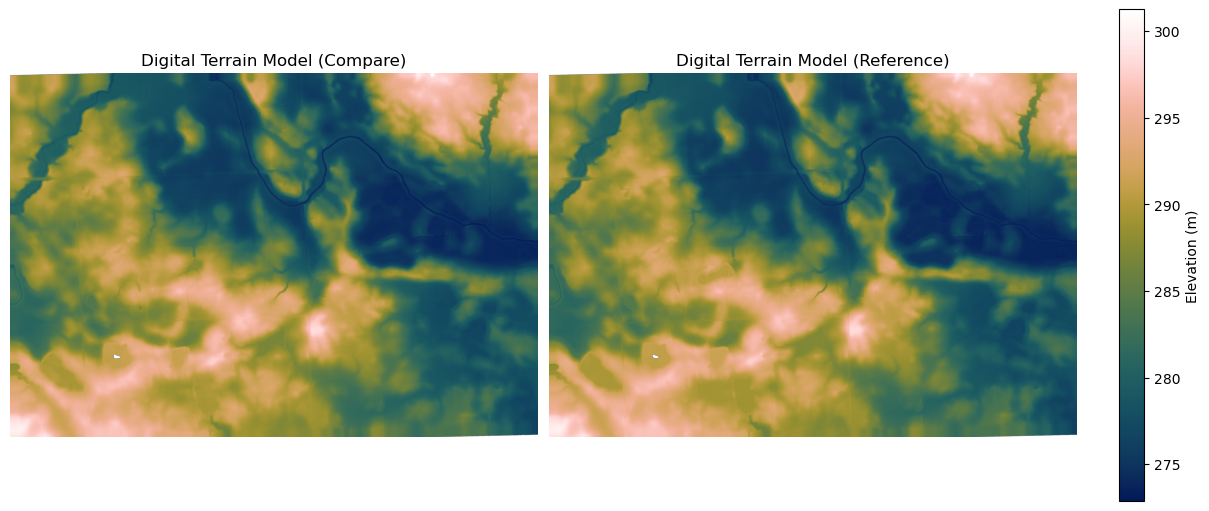

In [30]:
fig = change_dtms.plot_pair(
        overlay = None,
        titles=("Digital Terrain Model (Compare)", "Digital Terrain Model (Reference)"),
        base_cmap=cmaps.batloww,
        legend = "Elevation (m)",
    )

<h3 id="Hillshade">Compute and plot the compare and reference hillshade rasters</h3>

In [31]:
out_folder_der = "data/derivatives/"
td = TerrainDerivatives(out_folder_der)

compare_hillshade_dtm = Raster(td.hillshade(compare_dtm.path, azimuth=315, altitude=45))
reference_hillshade_dtm = Raster(td.hillshade(reference_dtm.path, azimuth=315, altitude=45))
hillshades_dtm = RasterPair(raster1 = compare_hillshade_dtm, raster2 = reference_hillshade_dtm)

compare_hillshade_dsm = Raster(td.hillshade(compare_dsm.path, azimuth=315, altitude=45))
reference_hillshade_dsm = Raster(td.hillshade(reference_dsm.path, azimuth=315, altitude=45))
hillshades_dsm = RasterPair(raster1 = compare_hillshade_dsm.path, raster2 = reference_hillshade_dsm.path)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/topographic_processing18.py:156: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


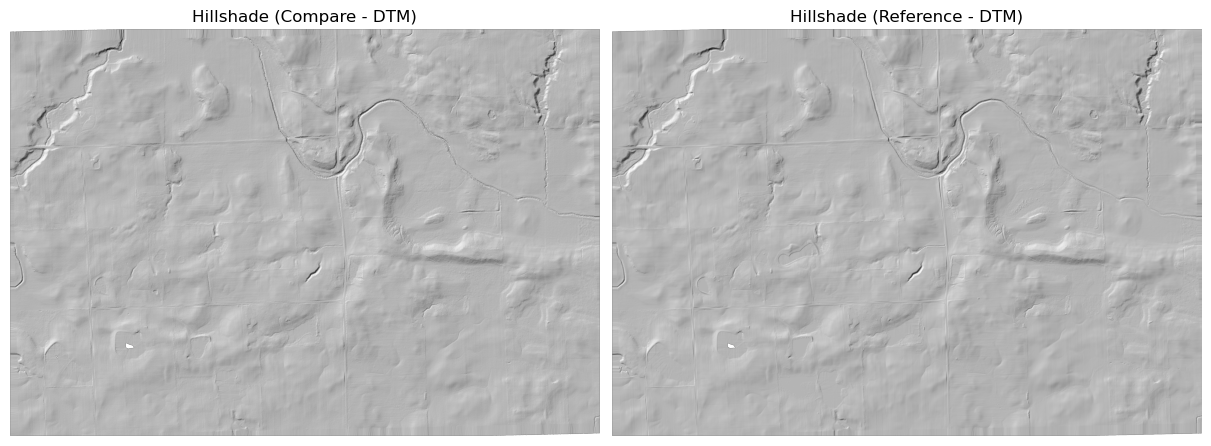

In [32]:
fig = hillshades_dtm.plot_pair(
        overlay = None,
        titles=("Hillshade (Compare - DTM)", "Hillshade (Reference - DTM)"),
        base_cmap=cmaps.gray,
    )

<h3 id="Slope">Compute and plot the compare and reference slope rasters</h3>

In [33]:
compare_slope_dtm = Raster(td.slope(compare_dtm.path))
reference_slope_dtm = Raster(td.slope(reference_dtm.path))
slope_dtm = RasterPair(raster1 = compare_slope_dtm, raster2 = reference_slope_dtm)


compare_slope_dsm = Raster(td.slope(compare_dsm.path))
reference_slope_dsm = Raster(td.slope(reference_dsm.path))
slope_dsm = RasterPair(raster1 = compare_slope_dsm, raster2 = reference_slope_dsm)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/topographic_processing18.py:156: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


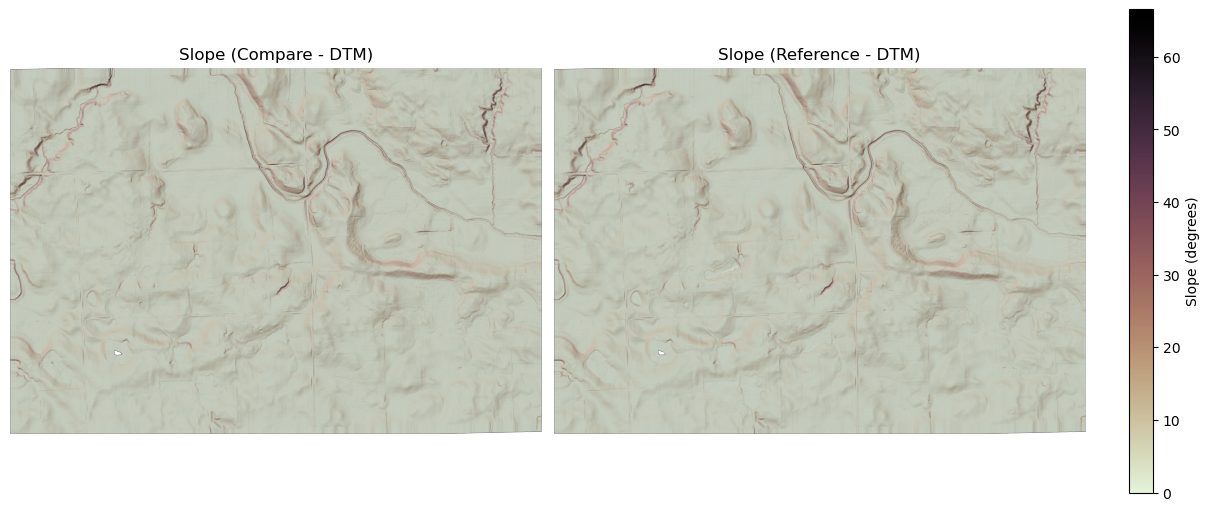

In [34]:
fig = slope_dtm.plot_pair(
        overlay = compare_hillshade_dtm,
        overlay_alpha = 0.5,
        titles=("Slope (Compare - DTM)", "Slope (Reference - DTM)"),
        base_cmap=cmaps.sepia_r,
        legend = "Slope (degrees)",
        overlay_cmap=cmaps.neutral,
          
    )

<h3 id="Aspect">Compute and plot the compare and reference aspect rasters</h3>

In [35]:
compare_aspect_dtm = Raster(td.aspect(compare_dtm.path))
reference_aspect_dtm = Raster(td.aspect(reference_dtm.path))
aspect_dtm = RasterPair(raster1 = compare_aspect_dtm, raster2 = reference_aspect_dtm)


compare_aspect_dsm = Raster(td.aspect(compare_dsm.path))
reference_aspect_dsm = Raster(td.aspect(reference_dsm.path))
aspect_dsm = RasterPair(raster1 = compare_aspect_dsm, raster2 = reference_aspect_dsm)


/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/topographic_processing18.py:156: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


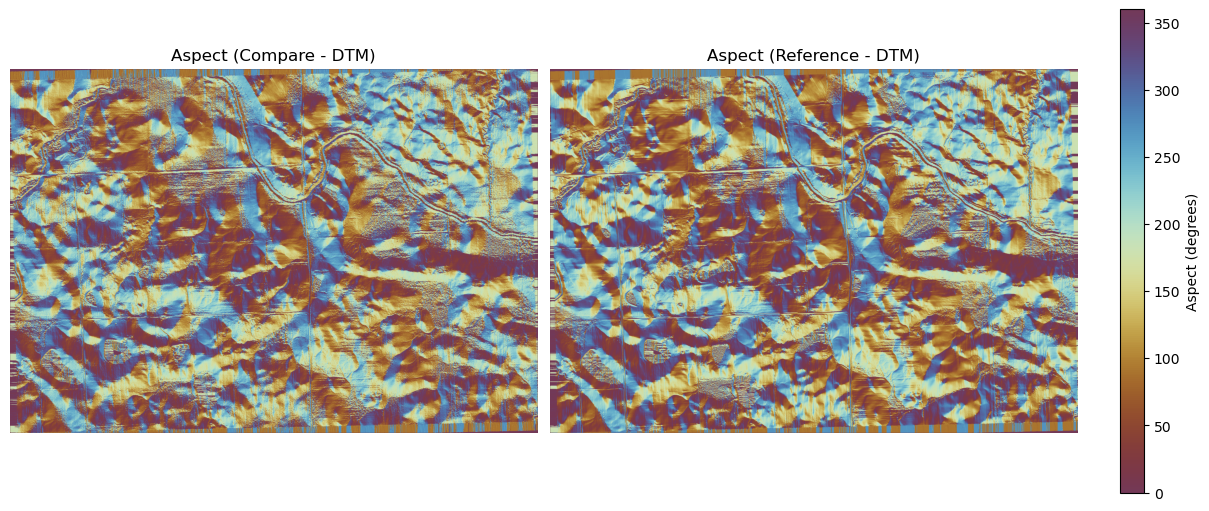

In [36]:
fig = aspect_dtm.plot_pair(
        overlay = None,
        titles=("Aspect (Compare - DTM)", "Aspect (Reference - DTM)"),
        base_cmap=cmaps.romao,
        legend = "Aspect (degrees)",
    )

<h3 id="Roughness">Compute and plot the compare and reference roughness rasters</h3>

In [37]:
compare_roughness_dtm = Raster(td.roughness(compare_dtm.path))
reference_roughness_dtm = Raster(td.roughness(reference_dtm.path))
roughness_dtm = RasterPair(raster1 = compare_roughness_dtm, raster2 = reference_roughness_dtm)


compare_roughness_dsm = Raster(td.roughness(compare_dsm.path))
reference_roughness_dsm = Raster(td.roughness(reference_dsm.path))
roughness_dsm = RasterPair(raster1 = compare_roughness_dsm, raster2 = reference_roughness_dsm)

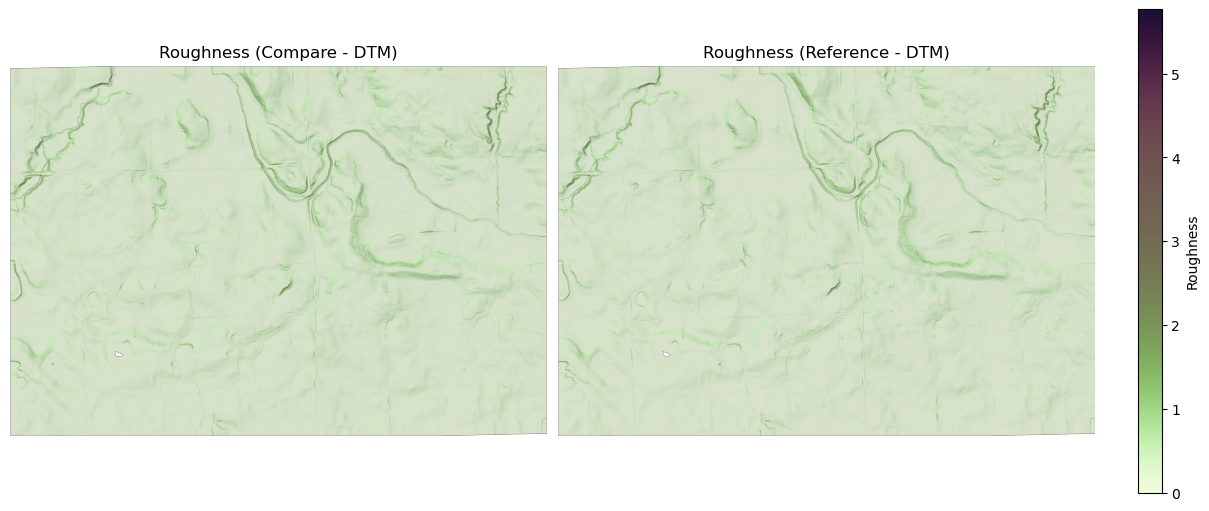

In [39]:
fig = roughness_dtm.plot_pair(
        overlay = compare_hillshade_dtm,
        overlay_alpha = 0.3,
        titles=("Roughness (Compare - DTM)", "Roughness (Reference - DTM)"),
        base_cmap=cmaps.tokyo_r,
        legend = "Roughness",
        overlay_cmap=cmaps.neutral,
    )

<h2 id="Differencing">4. Differencing</h2>

In [40]:
out_folder_diff = "data/differencing/"
topodiff = TopoDifferencer(out_folder_diff)

In [41]:
dtm_diff = topodiff.save_difference_raster(change_dtms, 'dtm_diff')

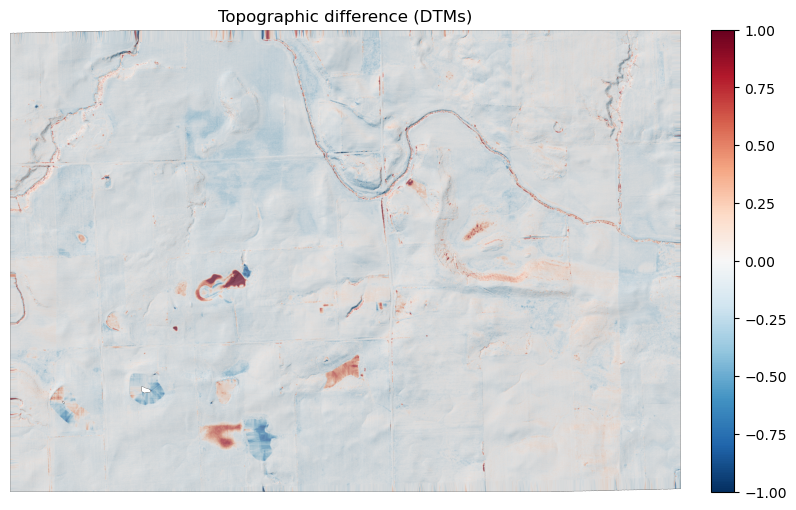

In [42]:
fig = topodiff.plot_difference(
        diff_path = dtm_diff.path,
        overlay = compare_hillshade_dtm,
        cmap="RdBu_r",
        vmin = -1,
        vmax = 1,
        center_zero = True,
        overlay_alpha = 0.4,
        title = "Topographic difference (DTMs)",
)

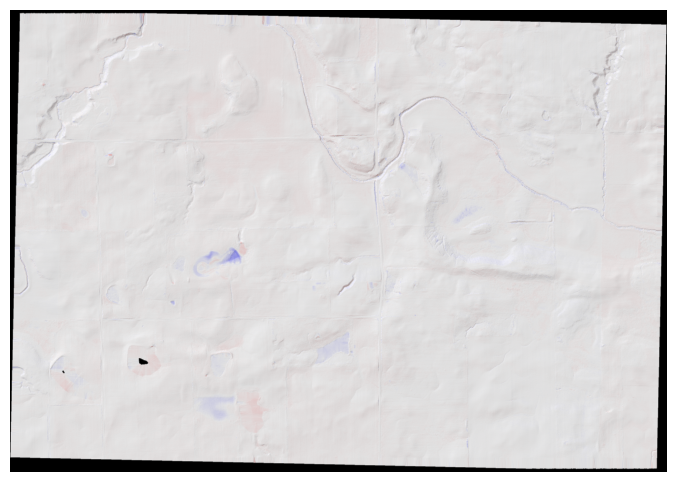

In [43]:
#Make PNG

proc = TopoDiffProcessor(
    topo_diff_path=dtm_diff.path,
    hillshade_path=compare_hillshade_dtm.path,
    data_dir=out_folder_diff
)
proc.align_and_crop()
proc.reproject_all()
proc.plot()

<h2 id="Error Analysis">5. Error Analysis</h2>

<h3 id="Define stable areas">Define stable areas</h3>


In [259]:
import importlib
import stable_unstable_areas
importlib.reload(stable_unstable_areas)

from stable_unstable_areas import TopoMapInteractor, StableAreaRasterizer, StableAreaAnalyzer

In [260]:
interactor = TopoMapInteractor(
    topo_diff_path=dtm_diff.path,
    hillshade_path=compare_hillshade_dtm.path,
    output_dir="out/"
)
# Display interactive map in a notebook
interactor.map

Map(center=[41.46382590602045, -85.10078746957245], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [261]:
interactor.stable_geoms

[<POLYGON ((-85.108 41.468, -85.11 41.466, -85.108 41.465, -85.105 41.466, -8...>]

<h4 id="Draw profiles and stable areas on interactive map"> Draw profiles and stable areas on interactive map</h4>

<h3 id="Descriptive Statistics">Descriptive Statistics</h3>

In [262]:
# assume 'interactor' is your TopoMapInteractor instance
gdf_poly, _ = interactor.get_geodataframes()

# one combined mask
rasterizer = StableAreaRasterizer(interactor.topo_diff.path, gdf_poly, nodata=-9999)
analyzer   = StableAreaAnalyzer(rasterizer)

# Combined-area stats
df_all = analyzer.stats_all('out/combined_stable.tif')

# Per-area stats
df_each = analyzer.stats_each('out/each_stable/')


In [263]:
df_all

mean    median      mode       std  variance      min  \
all_areas -0.119782 -0.115784 -0.098114  0.082212  0.006759 -0.94577   

                max  skewness  kurtosis  0.5_percentile  99.5_percentile  
all_areas  0.817352  0.694591  7.888556       -0.332404         0.195406

In [264]:
df_each

mean    median      mode       std  variance      min       max  \
area_id                                                                        
0       -0.119782 -0.115784 -0.098114  0.082212  0.006759 -0.94577  0.817352   

         skewness  kurtosis  0.5_percentile  99.5_percentile  
area_id                                                       
0        0.694591  7.888556       -0.332404         0.195406

<h3 id="Estimate systematic error">Estimate systematic error</h3>

In [265]:
vert_diff_path_dtm = 'out/combined_stable.tif'
output_path = 'out/combined_stable_bias_removed.tif'

unit = "m"
dem_resolution = 1.0

In [266]:
import importlib
import variography_uncertainty
importlib.reload(variography_uncertainty)

from variography_uncertainty import RasterDataHandler, StatisticalAnalysis, VariogramAnalysis, UncertaintyCalculation, ApplyUncertainty

In [267]:
import numpy as np
#Load raster data
raster_data_handler_dtm=RasterDataHandler(vert_diff_path_dtm, unit, dem_resolution)
raster_data_handler_dtm.load_raster()

vert_diff_array_dtm = raster_data_handler_dtm.data_array

#With the assumption that the distribution of vertical differences should be centered on zero given a large enough area, let's take the median as the measure of vertical bias.
vertical_bias = np.median(vert_diff_array_dtm)

#Get a measure of the uncertainty in the median value by bootstrap resampling (10% of the total observations, 1000x)
stats_dtm = StatisticalAnalysis(raster_data_handler_dtm)
median_uncertainty = stats_dtm.bootstrap_uncertainty_subsample()

#Subtract the vertical bias from the original raster and save as a file
raster_data_handler_dtm.subtract_value_from_raster(output_path, vertical_bias)

#Create new raster handling instance for modified raster, load raster and create data array
raster2_data_handler=RasterDataHandler(output_path, unit, dem_resolution)
raster2_data_handler.load_raster()


In [268]:
vertical_bias

np.float32(-0.11578369)

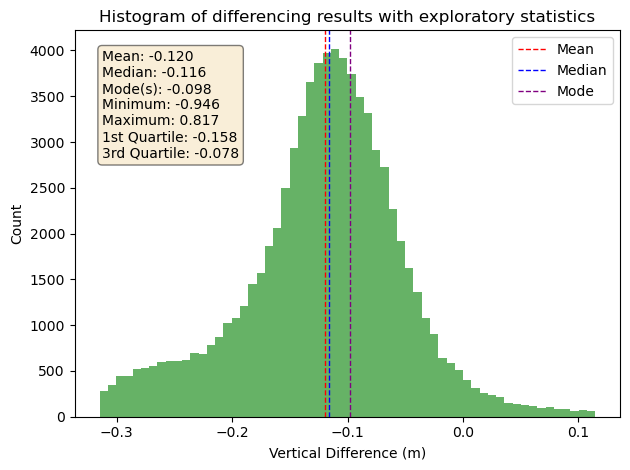

In [269]:
fig = stats_dtm.plot_data_stats()

<h3 id="Estimate correlated error">Estimate correlated error</h3>

In [270]:
#Create variogram analysis instance based on modified raster
V = VariogramAnalysis(raster2_data_handler)

#Calculate a mean variogram with 75 bins from variograms made over 10 runs
V.calculate_mean_variogram_numba(area_side = 250, samples_per_area = 400, max_samples = 1000000000, bin_width = 30, max_n_bins = 3000, n_runs = 30, max_lag_multiplier = 0.9)



In [271]:
V.fit_best_spherical_model()

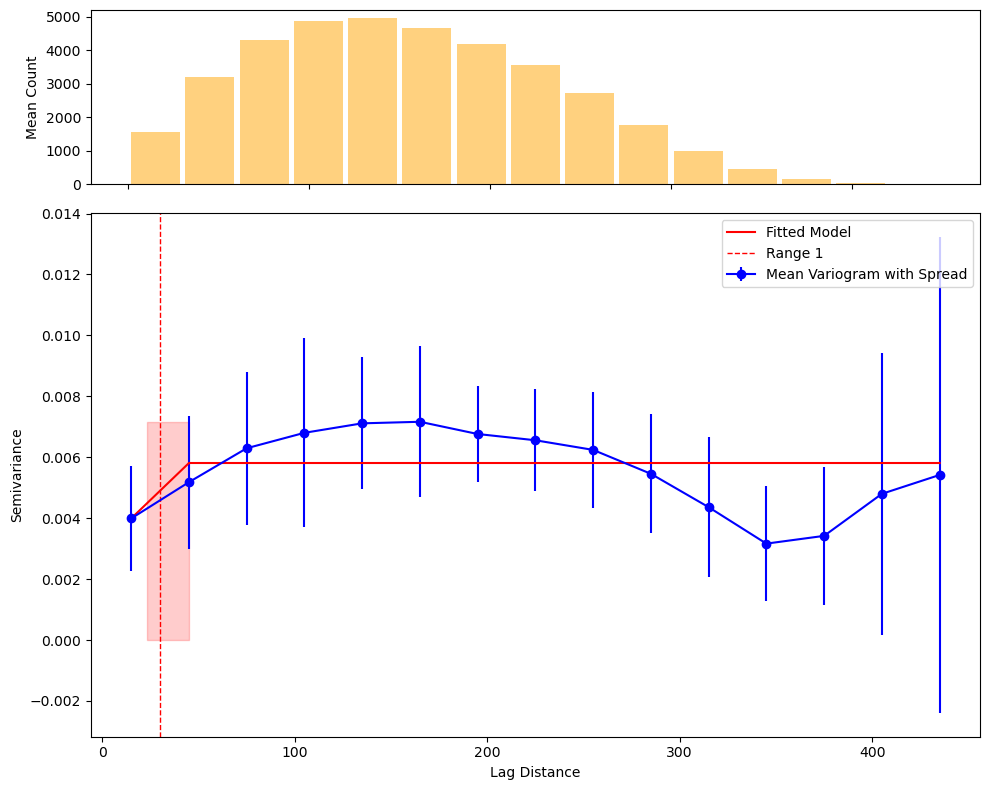

In [272]:
fig = V.plot_best_spherical_model()

<h3 id="Total mean error">Total mean error</h3>

In [273]:
uncertainty2 = UncertaintyCalculation(V)

#Calculate mean, random, uncorrelated uncertainty
uncertainty2.calc_mean_random_uncorrelated()

#Calculate mean, random, correlated uncertainty, for optimal, minimum and maximum ranges and sills 
uncertainty2.calc_mean_random_correlated()
uncertainty2.calc_mean_random_correlated_min()
uncertainty2.calc_mean_random_correlated_max()

#Calculate total mean uncertainty
uncertainty2.calc_total_mean_uncertainty()
uncertainty2.calc_total_mean_uncertainty_min()
uncertainty2.calc_total_mean_uncertainty_max()

In [274]:
print(f'vertical bias: {vertical_bias}')
print('')
print(f'component uncertainties: {uncertainty2.mean_random_correlated_1,uncertainty2.mean_random_correlated_2,uncertainty2.mean_random_correlated_3}')
print(f'max component uncertainties : {uncertainty2.mean_random_correlated_1_max,uncertainty2.mean_random_correlated_2_max,uncertainty2.mean_random_correlated_3_max}')
print(f'min component uncertainties : {uncertainty2.mean_random_correlated_1_min,uncertainty2.mean_random_correlated_2_min,uncertainty2.mean_random_correlated_3_min}')   
print('')
print(f'mean random uncorrelated uncertainty : {uncertainty2.mean_random_uncorrelated}')
print('')
print(f'total mean uncertainty : {uncertainty2.total_mean_uncertainty}')
print(f'max total mean uncertainty : {uncertainty2.total_mean_uncertainty_max}')
print(f'min total mean uncertainty : {uncertainty2.total_mean_uncertainty_min}')
print('')
print(f'area (m^2): {len(raster2_data_handler.data_array)}')

vertical bias: -0.11578369140625

component uncertainties: (np.float64(0.009182459689721758), None, None)
max component uncertainties : (np.float64(0.014717886281507577), None, None)
min component uncertainties : (np.float64(0.006442943732449153), None, None)

mean random uncorrelated uncertainty : 0.000294417046985349

total mean uncertainty : 0.009187178421633085
max total mean uncertainty : 0.014720830750774377
min total mean uncertainty : 0.0064496670718000165

area (m^2): 78157


In [275]:
interactor.map

Map(bottom=3131136.0, center=[41.46382590602045, -85.10078746957245], controls=(ZoomControl(options=['position…

In [277]:
interactor.unstable_geoms

[<POLYGON ((-85.091 41.467, -85.095 41.464, -85.092 41.463, -85.091 41.467))>]

In [279]:
# 1) compute RMS:
rms = ApplyUncertainty.compute_rms_from_tif('out/combined_stable_bias_removed.tif')

# 2) compute uncertainties:
unc = ApplyUncertainty.compute_spatial_uncertainties(
    V.ranges, V.sills,
    area=unstable_area_m2,
    resolution=dem_resolution,
    rms=rms,
    sills_min=V.sills_min,
    ranges_min=V.ranges_min,
    sills_max=V.sills_max,
    ranges_max=V.ranges_max,
)
print(unc)

{'uncorrelated': 0.00012650456736296615, 'correlated': [0.0039454800982982865], 'total': 0.003947507645544407, 'total_min': 0.0027712654592124577, 'total_max': 0.0063251837579453764}
